In [1]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import os
from tensorflow.keras.preprocessing.image import load_img
import random
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dropout, concatenate, BatchNormalization, Dense, Flatten
from tensorflow.keras.optimizers import Adam

from google.colab.patches import cv2_imshow
import glob
from random import randint
from PIL import Image

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

GDRIVE_PATH = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
paths = ['/content/drive/MyDrive/Fake Face Data/training_fake', '/content/drive/MyDrive/Fake Face Data/training_real']
labels = ['fake', 'real']
dfs = []

files = []
for p in os.listdir(paths[0]):
  if p.split("_")[0] in ['easy', 'mid']:
    if os.path.isfile(os.path.join(paths[0],p)):
        t = [paths[0]+"/"+p,labels[0]]
        files.append(t)
df = pd.DataFrame(files,columns=["img", "label"])
df_fake = df.sample(frac=1, random_state=22)

files = []
for p in os.listdir(paths[1]):
  if os.path.isfile(os.path.join(paths[1],p)):
      t = [paths[1]+"/"+p,labels[1]]
      files.append(t)
df = pd.DataFrame(files,columns=["img", "label"])
df_real = df.sample(n=len(df_fake), random_state=22)

df_face = pd.concat([df_fake, df_real], axis=0)
df_face = df_face.sample(frac=1, random_state=22)

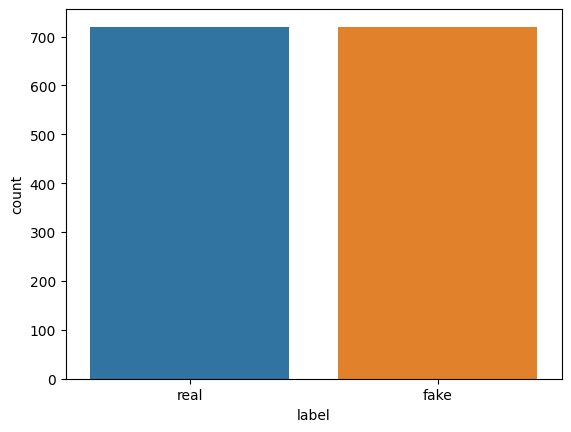

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df_face, x='label')
plt.show()

## Augmentation

In [ ]:
train_df, test_df = train_test_split(df_face, test_size=0.1, random_state=22)
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [ ]:
X_train = train_df['img']
y_train = train_df['label']

X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

In [ ]:
X_train = X_train.apply(lambda x: cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB))
X_train = X_train.apply(lambda x: cv2.resize(x, (224,224), interpolation=cv2.INTER_NEAREST))
X_train = np.array(X_train)

In [ ]:
def random_rotation(x_image, y):
  rows_x,cols_x, _ = x_image.shape
  rand_num = np.random.randint(-10,10)
  M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
  x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
  return x_image, y

def horizontal_flip(x_image, y):
  x_image = cv2.flip(x_image, 1)
  return x_image, y

In [ ]:
X_rotate, y_rotate = [], []
X_horizontal_flip, y_horizontal_flip = [], []

for idx in range(len(X_train)):
  X, y = random_rotation(X_train[idx], y_train[idx])
  X_rotate.append(X_train[idx])
  y_rotate.append(y_train[idx])

for idx in range(len(X_train)):
  X,y = horizontal_flip(X_train[idx], y_train[idx])
  X_horizontal_flip.append(X)
  y_horizontal_flip.append(y)

In [ ]:
for i in range(len(X_train)):
  if y_train[i] == 'real':
    image = Image.fromarray(X_train[i])
    image.save(f'/content/drive/MyDrive/Fake Face Data/real_augmented/real_train_{i}.png', 'png')
  elif y_train[i] == 'fake':
    image = Image.fromarray(X_train[i])
    image.save(f'/content/drive/MyDrive/Fake Face Data/fake_augmented/fake_train_{i}.png', 'png')

for i in range(len(X_rotate)):
  if y_rotate[i] == 'real':
    image = Image.fromarray(X_rotate[i])
    image.save(f'/content/drive/MyDrive/Fake Face Data/real_augmented/real_rotated_{i}.png', 'png')
  elif y_rotate[i] == 'fake':
    image = Image.fromarray(X_rotate[i])
    image.save(f'/content/drive/MyDrive/Fake Face Data/fake_augmented/fake_rotated_{i}.png', 'png')

for i in range(len(X_horizontal_flip)):
  if y_horizontal_flip[i] == 'real':
    image = Image.fromarray(X_horizontal_flip[i])
    image.save(f'/content/drive/MyDrive/Fake Face Data/real_augmented/real_flip_{i}.png', 'png')
  elif y_horizontal_flip[i] == 'fake':
    image = Image.fromarray(X_horizontal_flip[i])
    image.save(f'/content/drive/MyDrive/Fake Face Data/fake_augmented/fake_flip_{i}.png', 'png')

In [ ]:
for i in range(len(test_df)):
  img = cv2.cvtColor(cv2.imread(test_df['img'][i]), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST)
  img = Image.fromarray(img)
  if test_df['label'][i] == 'real':
    img.save(f'/content/drive/MyDrive/Fake Face Data/testing/real_test_{i}.png', 'png')
  else:
    img.save(f'/content/drive/MyDrive/Fake Face Data/testing/fake_test_{i}.png', 'png')

## Get the Dataset

In [ ]:
paths = ['/content/drive/MyDrive/Fake Face Data/fake_augmented', '/content/drive/MyDrive/Fake Face Data/real_augmented']
labels = ['fake', 'real']
dfs = []

for i in range(0,len(paths)):
    files = []
    for p in os.listdir(paths[i]):
        if os.path.isfile(os.path.join(paths[i],p)):
            t = [paths[i]+"/"+p,labels[i]]
            files.append(t)
    df = pd.DataFrame(files,columns=["img","label"])
    dfs.append(df)
dfrop = pd.concat(dfs,axis=0)
train_df = dfrop.sample(frac=1, random_state=22)
train_df.reset_index(inplace=True, drop=True)

In [ ]:
path = '/content/drive/MyDrive/Fake Face Data/testing'

files = []
for p in os.listdir(path):
  if os.path.isfile(os.path.join(path,p)):
    t = [path+"/"+p, p.split("_")[0]]
    files.append(t)
df = pd.DataFrame(files, columns=["img", "label"])
test_df = df.sample(frac=1, random_state=22)
test_df.reset_index(inplace=True, drop=True)

In [ ]:
# train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
#     rotation_range=45,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=False,
#     fill_mode='nearest',
#     validation_split=0.2)

# test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='img',
    y_col='label',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='img',
    y_col='label',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='img',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 3111 validated image filenames belonging to 2 classes.
Found 777 validated image filenames belonging to 2 classes.
Found 144 validated image filenames belonging to 2 classes.


In [ ]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',
    pooling='avg')

pretrained_model.trainable = False

resnet50 = Flatten()(pretrained_model.output)
# resnet50 = Dense(512, activation='relu')(resnet50)
# dropout = tf.keras.layers.Dropout(0.5)(resnet50)
# resnet50 = Dense(256, activation='relu')(dropout)
resnet50 = Dense(2, activation='softmax')(resnet50)

model = Model(inputs=pretrained_model.input, outputs=resnet50)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(train_images, validation_data=val_images, epochs=20)

Epoch 1/20
98/98 [==============================] - 39s 274ms/step - loss: 0.7171 - accuracy: 0.5831 - precision: 0.5831 - recall: 0.5831 - val_loss: 0.5961 - val_accuracy: 0.6770 - val_precision: 0.6770 - val_recall: 0.6770
Epoch 2/20
98/98 [==============================] - 21s 218ms/step - loss: 0.5982 - accuracy: 0.6673 - precision: 0.6673 - recall: 0.6673 - val_loss: 0.5598 - val_accuracy: 0.7143 - val_precision: 0.7143 - val_recall: 0.7143
Epoch 3/20
98/98 [==============================] - 22s 223ms/step - loss: 0.5273 - accuracy: 0.7313 - precision: 0.7313 - recall: 0.7313 - val_loss: 0.5285 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 0.7375
Epoch 4/20
98/98 [==============================] - 23s 237ms/step - loss: 0.4878 - accuracy: 0.7724 - precision: 0.7724 - recall: 0.7724 - val_loss: 0.5078 - val_accuracy: 0.7555 - val_precision: 0.7555 - val_recall: 0.7555
Epoch 5/20
98/98 [==============================] - 23s 233ms/step - loss: 0.4634 - accuracy: 0.7830

In [ ]:
model.save('/content/drive/MyDrive/Fake Face Data/fake_face.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
load_model = keras.models.load_model('/content/drive/MyDrive/Fake Face Data/fake_face.h5')

In [6]:
from joblib import dump

dump(load_model, '/content/drive/MyDrive/Fake Face Data/fake_face.pkl')

['/content/drive/MyDrive/Fake Face Data/fake_face.pkl']

Actual : real
Prediction : real


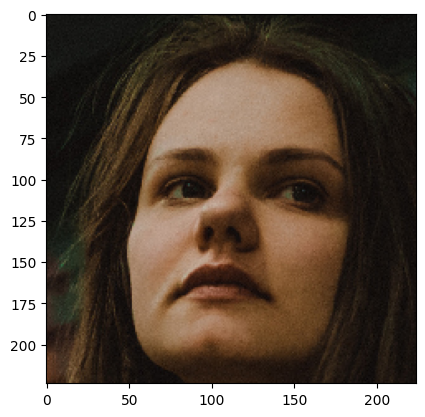

In [ ]:
def show_img(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def prepare(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img.reshape(1, 224, 224, 3)

def predict_image(img_path):
  pred = np.argmax(load_model.predict([prepare(img_path)], verbose=0))
  if pred == 0:
    return 'fake'
  else:
    return 'real'

print(f"Actual : {test_df['label'][22]}")
# print(f"Prediction : {load_model.predict(prepare(test_df['img'][22]), verbose=0)}")
print(f"Prediction : {predict_image(test_df['img'][22])}")

plt.imshow(show_img(test_df['img'][22]))
plt.show()

In [ ]:
print(f"Accuracy : {np.round(load_model.evaluate(test_images, verbose=0)[1]*100, 2)}")

Accuracy : 61.11


In [ ]:
test_df['img'][32]

'/content/drive/MyDrive/Fake Face Data/testing/fake_test_26.png'

In [ ]:
def prepare(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224))
  # img_array = np.array(img)
  # img_reshape = img.reshape(1, 224, 224, 3)
  return img

prepare(test_df['img'][0])

array([[[135, 127,  91],
        [130, 125,  90],
        [124, 121,  87],
        ...,
        [227, 220, 210],
        [228, 221, 211],
        [227, 221, 210]],

       [[128, 119,  85],
        [126, 121,  87],
        [127, 124,  91],
        ...,
        [227, 218, 209],
        [227, 218, 209],
        [228, 219, 210]],

       [[132, 123,  90],
        [126, 120,  88],
        [119, 116,  85],
        ...,
        [229, 219, 206],
        [229, 220, 207],
        [230, 220, 207]],

       ...,

       [[142, 129,  77],
        [147, 133,  80],
        [149, 134,  79],
        ...,
        [113, 106,  88],
        [103,  97,  82],
        [ 96,  96,  84]],

       [[142, 129,  77],
        [143, 130,  77],
        [149, 134,  79],
        ...,
        [104,  97,  79],
        [107, 101,  86],
        [ 98,  96,  82]],

       [[144, 131,  79],
        [144, 131,  78],
        [144, 129,  74],
        ...,
        [109, 100,  83],
        [117, 110,  94],
        [ 94,  93,  77]]